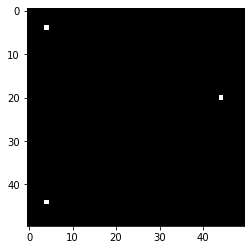

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 50x50 grid filled with zeros (black)
grid = np.zeros((50, 50))

# Set a couple of white elements by specifying their positions
# For example, let's set the element at row 10, column 20 and row 30, column 40 to white.
grid[4, 4] = 1  # White
grid[44, 4] = 1  # White
grid[20, 44] = 1  # White

# Display the grid
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.show()


In [36]:
data['Combi_0'] 

('OODatasets/imagenet_val_resized/n02106662/ILSVRC2012_val_00022142_n02106662.JPEG',
 'OODatasets/imagenet_val_resized/n03388043/ILSVRC2012_val_00023645_n03388043.JPEG',
 'OODatasets/imagenet_val_resized/n03594945/ILSVRC2012_val_00018474_n03594945.JPEG')

In [31]:
class_labels_dict[459]

'brassiere, bra, bandeau'

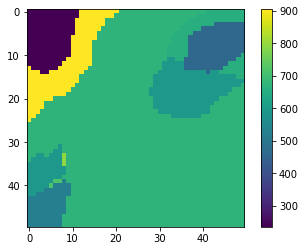

In [29]:
import matplotlib.pyplot as plt
import pickle

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

path_results = '/net/travail/jpenatrapero/results/results_3_3_imagenet_original.pkl'
with open(path_results, 'rb') as file:
    data = pickle.load(file)

# Read the class labels from the file
with open('imagenet1klabels.txt', 'r') as file:
    class_labels_dict = eval(file.read())
# List the keys in the dictionary
keys = data.keys()




# Create an image (replace this with your matrix)
matrix = data['Matrix_0']  # Your 50x50 matrix of class labels

def on_click(event):
    if event.inaxes is not None:
        x, y = int(event.xdata), int(event.ydata)
        value = matrix[y, x]
        ax.set_title(f'Value at ({x}, {y}): {value}')
# Create a sample 50x50 matrix (you can use your own data)

# Define a colormap for different colors
cmap = plt.get_cmap('viridis')  # You can choose a different colormap

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the matrix as an image with colors
img = ax.imshow(matrix, cmap=cmap)

# Add a colorbar for reference
cbar = plt.colorbar(img)




# Connect the click event to the function
fig.canvas.mpl_connect('button_press_event', on_click)

# Display the figure with interactivity
plt.show()




In [35]:
keys

dict_keys(['Matrix_0', 'Combi_0', 'Matrix_1', 'Combi_1', 'Matrix_2', 'Combi_2', 'Matrix_3', 'Combi_3', 'Matrix_4', 'Combi_4', 'Matrix_5', 'Combi_5', 'Matrix_6', 'Combi_6', 'Matrix_7', 'Combi_7', 'Matrix_8', 'Combi_8', 'Matrix_9', 'Combi_9', 'Matrix_10', 'Combi_10', 'Matrix_11', 'Combi_11', 'Matrix_12', 'Combi_12', 'Matrix_13', 'Combi_13', 'Matrix_14', 'Combi_14', 'Matrix_15', 'Combi_15', 'Matrix_16', 'Combi_16', 'Matrix_17', 'Combi_17', 'Matrix_18', 'Combi_18', 'Matrix_19', 'Combi_19', 'Matrix_20', 'Combi_20', 'Matrix_21', 'Combi_21', 'Matrix_22', 'Combi_22', 'Matrix_23', 'Combi_23', 'Matrix_24', 'Combi_24', 'Matrix_25', 'Combi_25', 'Matrix_26', 'Combi_26'])